In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
import cv2
import torch
import pywt
from torch import nn
from torchsummary import summary
from torch.optim import SGD
import torch.optim as optim
from tensorflow.keras.utils import array_to_img, img_to_array
from torch.autograd import Variable
from scipy import ndimage
import skimage
from skimage import exposure

# Iterate over the files in the specified directory and its subdirectories
for dirname, _, filenames in os.walk('/kaggle/input/pancreasct-dataset'):
    for filename in filenames:
        # Print the full path of each file
        print(os.path.join(dirname, filename))
filepath="/kaggle/input/pancreasct-dataset"

2024-08-06 19:13:57.081936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 19:13:57.082113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 19:13:57.236745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/pancreasct-dataset/labels/0076.npy
/kaggle/input/pancreasct-dataset/labels/0036.npy
/kaggle/input/pancreasct-dataset/labels/0018.npy
/kaggle/input/pancreasct-dataset/labels/0015.npy
/kaggle/input/pancreasct-dataset/labels/0059.npy
/kaggle/input/pancreasct-dataset/labels/0081.npy
/kaggle/input/pancreasct-dataset/labels/0069.npy
/kaggle/input/pancreasct-dataset/labels/0033.npy
/kaggle/input/pancreasct-dataset/labels/0001.npy
/kaggle/input/pancreasct-dataset/labels/0047.npy
/kaggle/input/pancreasct-dataset/labels/0025.npy
/kaggle/input/pancreasct-dataset/labels/0030.npy
/kaggle/input/pancreasct-dataset/labels/0058.npy
/kaggle/input/pancreasct-dataset/labels/0051.npy
/kaggle/input/pancreasct-dataset/labels/0063.npy
/kaggle/input/pancreasct-dataset/labels/0046.npy
/kaggle/input/pancreasct-dataset/labels/0016.npy
/kaggle/input/pancreasct-dataset/labels/0012.npy
/kaggle/input/pancreasct-dataset/labels/0020.npy
/kaggle/input/pancreasct-dataset/labels/0045.npy
/kaggle/input/pancre

In [3]:
# Initialize empty lists to store file paths
imageFiles = []  # List to store paths of image files
labelFiles = []  # List to store paths of label files
imageFiles = []
labelFiles = []

# Iterate over the files in the specified directory and its subdirectories
for dirname, _, filenames in os.walk(filepath+'/labels'):
    for filename in filenames:
        # Check if the file has the '.npy' extension
        if filename.endswith('.npy'):
            # Append the path of the corresponding image file and label file to their respective lists
            imageFiles.append(os.path.join(filepath+'/images', filename))  # Append image file path
            labelFiles.append(os.path.join(dirname, filename))  # Append label file path

# Remove specific items from the lists
imageFiles.pop(58)
labelFiles.pop(58)

# Print the modified lists
print(imageFiles)  # Print the list of image file paths
print(labelFiles)  # Print the list of label file paths

['/kaggle/input/pancreasct-dataset/images/0076.npy', '/kaggle/input/pancreasct-dataset/images/0036.npy', '/kaggle/input/pancreasct-dataset/images/0018.npy', '/kaggle/input/pancreasct-dataset/images/0015.npy', '/kaggle/input/pancreasct-dataset/images/0059.npy', '/kaggle/input/pancreasct-dataset/images/0081.npy', '/kaggle/input/pancreasct-dataset/images/0069.npy', '/kaggle/input/pancreasct-dataset/images/0033.npy', '/kaggle/input/pancreasct-dataset/images/0001.npy', '/kaggle/input/pancreasct-dataset/images/0047.npy', '/kaggle/input/pancreasct-dataset/images/0025.npy', '/kaggle/input/pancreasct-dataset/images/0030.npy', '/kaggle/input/pancreasct-dataset/images/0058.npy', '/kaggle/input/pancreasct-dataset/images/0051.npy', '/kaggle/input/pancreasct-dataset/images/0063.npy', '/kaggle/input/pancreasct-dataset/images/0046.npy', '/kaggle/input/pancreasct-dataset/images/0016.npy', '/kaggle/input/pancreasct-dataset/images/0012.npy', '/kaggle/input/pancreasct-dataset/images/0020.npy', '/kaggle/in

In [4]:
# Define the depth of the image in pixels
im_depth = 162

# Define the height of the image in pixels
im_height = 300

# Define the width of the image in pixels
im_width = 300

In [5]:
# Declaring an empty NumPy array to store all slices for training images
trainImages = 80-8-8  # Number of training images

# Calculating the number of testing images
testImages = 8

# Calculating the number of validation images
valImages = 8

In [6]:
def remove_background1(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) + (np.std(img1)*0.0))
    threshold1 = (np.mean(img1) + (np.std(img1)*1.5))

    # Apply thresholding to remove background
    if threshold>=0:
        return (((threshold) < img) * ((threshold1) >= img) * (img))+((threshold1 < img)*threshold1)
    else:
        return (((threshold) < img) * ((threshold1) >= img) * (img - threshold))+((threshold1 < img)*(threshold1-threshold))

In [7]:
def remove_background(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) - (np.std(img1)*1.0))

    # Apply thresholding to remove background
    return (((threshold) < img) * (img - threshold))

In [8]:
def remove_background2(img):
    """
    Function to remove background from an image tensor based on a threshold.

    Args:
    - img: Input image tensor

    Returns:
    - Tensor with background removed
    """

    # Flatten the tensor to a 1D array
    #img = torch.Tensor(img)  # Convert input to a PyTorch tensor
    #tensor_flattened = img.flatten()  # Flatten the tensor to 1D array
    img1=img.flatten()
    # Calculate the threshold based on the mean and standard deviation of pixel values
    threshold = (np.mean(img1) - (np.std(img1)*3.0))
    threshold1 = (np.mean(img1) + (np.std(img1)*3.0))

    # Apply thresholding to remove background
    if threshold>=0:
        return (((threshold) < img) * ((threshold1) >= img) * (img))+((threshold1 < img)*threshold1)
    else:
        return (((threshold) < img) * ((threshold1) >= img) * (img - threshold))+((threshold1 < img)*(threshold1-threshold))

In [9]:
# Function to normalize image
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val)
    return image,(max_val - min_val)

In [10]:
def process_image(imageFile):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)
    
    #img = np.flip(img, axis=1)

    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()

    # Convert the image array to a PyTorch tensor
    img=np.resize(img, (1, im_depth, im_height, im_width))
    img1=img
    img,val=normalize_image(img)
    
    img=remove_background1(img)
    
    # Apply CLAHE to the 3D image
    clahe = skimage.exposure.equalize_adapthist
    img = clahe(img, clip_limit=2.00)

    return torch.Tensor(img),img1

def process_image(imageFile):
    """
    Process an image file.

    Args:
    - imageFile: Path to the image file

    Returns:
    - Processed image tensor
    """

    # Load the image file using NumPy
    img = np.load(imageFile)

    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]

    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the image array
    img = image.transpose()

    # Convert the image array to a PyTorch tensor
    img=np.resize(img, (1, im_depth, im_height, im_width))
    img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    clahe = skimage.exposure.equalize_adapthist
    img = clahe(img, clip_limit=0.01)
    img2=img
    img=remove_background1(img)

    img=(img*val).numpy()
    img=np.resize(img, (1,1, im_depth, im_height, im_width))
    img2=np.resize(img2, (1,1, im_depth, im_height, im_width))
    return torch.Tensor(img),torch.Tensor(img2)

In [11]:
# Define the batch size for processing data in mini-batches
BATCH_SIZE = 1

In [12]:
# Load pre-trained models from saved checkpoints
modelx = torch.load('/kaggle/input/rcnn_ct/pytorch/default/1/checkpointr_x.pt')
modely = torch.load('/kaggle/input/rcnn_ct/pytorch/default/1/checkpointr_y.pt')
modelz = torch.load('/kaggle/input/rcnn_ct/pytorch/default/1/checkpointr_z.pt')

/opt/conda/lib/python3.10/site-packages/torch/serialization.py:995: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [13]:
# Move the pre-trained models to the GPU for computation
modelx.cuda()
modely.cuda()
modelz.cuda()

RecursiveScriptModule(
  original_name=RCNN
  (bn): RecursiveScriptModule(original_name=BatchNorm3d)
  (a_block1): RecursiveScriptModule(
    original_name=Conv3DBlockn
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (max1): RecursiveScriptModule(original_name=MaxPool3d)
  (a_block2): RecursiveScriptModule(
    original_name=Conv3DBlock
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv3d)
      (1): RecursiveScriptModule(original_name=BatchNorm3d)
      (2): RecursiveScriptModule(original_name=LeakyReLU)
    )
  )
  (max2): RecursiveScriptModule(original_name=MaxPool3d)
  (a_block3): RecursiveScriptModule(
    original_name=Conv3DBlock
    (conv1): RecursiveScriptModule(
      original_name=Sequential
      (0): Recur

In [14]:
# Initialize variables x, y, and z to zero
x = 0
y = 0
z = 0

In [15]:
def process_label(labelFile):
    img = np.load(labelFile)
    #print(img.shape)
    Z_Front=34
    Z_Back=196
    if img.shape[2]<Z_Back:
        Z_Front=Z_Front-(Z_Back-img.shape[2])
        Z_Back=img.shape[2]
    
    
    #print('label shape',img.shape)
    # Crop the image based on specified dimensions
    image = img[150:450, 150:450, Z_Front:Z_Back]

    # Transpose the label image array
    image = image.transpose()
    #print('label shape',image.shape)
    
    # Convert the image array to a PyTorch tensor
    img=np.resize(image, (1, 1, im_depth, im_height, im_width))
    
    img= np.array(img, dtype=np.int8)
    return torch.Tensor(img)

In [16]:
def resize_mid(x, val, val2):
    array1 = np.arange(0, val2)
    x=np.array(x*array1)
    x = set(x.flatten())
    x = np.array(list(x))
    median_val=np.median(x)
    front=int(median_val-(val/2))
    back=front+val
    
    # Check if back index exceeds the desired shape, adjust front and back indices accordingly
    if back > (val2):
        front = front - (back - (val2))
        back = val2
    # Check if front index is less than zero, adjust front and back indices accordingly
    elif front < 0:
        back = back - front
        front = 0
    
    return front, back

In [17]:
def get_array_output(yhatz,length,length2):
    frontz, backz = resize_mid(yhatz, length, length2)
    output1=np.zeros(length2)
    output2=np.ones(backz-frontz)
    #print("  z:", backz + 1, frontz)
    output1[frontz:backz]=output2
    output1=np.resize(output1,(1,length2))
    #output1 = torch.Tensor(output1)
    #output1 = Variable(output1, requires_grad=True).type(dtype)
    return output1

In [18]:
def clean_array(x):
    # Initialize variables to store the indices of the predicted boundary
    #x=x.cpu().detach().numpy()
    #print('clean array',x.shape)
    front = 0
    back = x.shape[1] - 1
    
    # Find the front boundary of the predicted array
    while x[0][front] == 0:
        front = front + 1
        
    # Find the back boundary of the predicted array
    while x[0][back] == 0:
        back = back - 1
        
    # Return the indices of the predicted boundary
    return front, back

In [19]:
# Define the dimensions of an image volume
im_depth1 = 128   # Depth of the image volume
im_height1 = 208  # Height of the image volume
im_width1 = 208  # Width of the image volume

In [20]:
# Declaring an empty NumPy array to store all slices for training images

# Initializing an empty array with dimensions (trainImages, 1, im_height, im_width, im_depth) filled with zeros and of integer data type
X_train = np.zeros((trainImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_train.shape)  # Print the shape of the array

# Initializing an empty array for training labels with dimensions (trainImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_train = np.zeros((trainImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_train.shape)  # Print the shape of the array

# Declaring an empty NumPy array to store all slices for testing images
X_test = np.zeros((testImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_test.shape)  # Print the shape of the array

# Initializing an empty array for testing labels with dimensions (testImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_test = np.zeros((testImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_test.shape)  # Print the shape of the array

# Declaring an empty NumPy array to store all slices for validation images
X_val = np.zeros((valImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(X_val.shape)  # Print the shape of the array

# Initializing an empty array for validation labels with dimensions (valImages, 1, im_height, im_width, im_depth) filled with zeros and of float32 data type
y_val = np.zeros((valImages, 1, im_depth1, im_height1, im_width1), dtype=np.float32)
print(y_val.shape)  # Print the shape of the array

(64, 1, 128, 208, 208)
(64, 1, 128, 208, 208)
(8, 1, 128, 208, 208)
(8, 1, 128, 208, 208)
(8, 1, 128, 208, 208)
(8, 1, 128, 208, 208)


In [21]:
# Define the data type for tensors to be stored on the GPU
dtype = torch.cuda.FloatTensor

In [22]:
li=[]

In [23]:
loss_checkpoint = 1000
count = 0
loss = 0
val_loss = 0

# Evaluate the model
for i in range(0, trainImages):
    # Process input and label images
    img,img1=process_image(imageFiles[i])
    X=img
    Y = process_label(labelFiles[i])
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img = img1[:,frontz:backz, frontx:backx, fronty:backy]
    img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    img=remove_background2(img)
    #clahe = skimage.exposure.equalize_adapthist
    
    #img=remove_background2(img)
    #img = clahe(img, clip_limit=2.00)

    # Resize and store input images
    X_train[i] = np.resize(img, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_img = y_img[:,:,frontz:backz, frontx:backx, fronty:backy]
    y_train[i] = np.resize(y_img.cpu().numpy(), (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(sum(y_img))))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(sum(y_img))))) / sum(sum(sum(sum(sum(Y))))))

1 

  z: 128
   x: 208
 y: 208
   x: 149    21    x: 212    4    y: 263    55
tensor(71998.)    tensor(72003.)    Pancreas percentage: tensor(0.9999)
2 

  z: 128
   x: 208
 y: 208
   x: 129    1    x: 261    53    y: 208    0
tensor(112025.)    tensor(112025.)    Pancreas percentage: tensor(1.)
3 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 217    9    y: 243    35
tensor(87441.)    tensor(87441.)    Pancreas percentage: tensor(1.)
4 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 231    23    y: 208    0
tensor(104562.)    tensor(111910.)    Pancreas percentage: tensor(0.9343)
5 

  z: 128
   x: 208
 y: 208
   x: 146    18    x: 208    0    y: 214    6
tensor(56427.)    tensor(58897.)    Pancreas percentage: tensor(0.9581)
6 

  z: 128
   x: 208
 y: 208
   x: 141    13    x: 211    3    y: 212    4
tensor(58571.)    tensor(58571.)    Pancreas percentage: tensor(1.)
7 

  z: 128
   x: 208
 y: 208
   x: 157    29    x: 214    6    y: 250    42
tensor(117207.)    tensor(118311.

<Figure size 8000x5000 with 0 Axes>

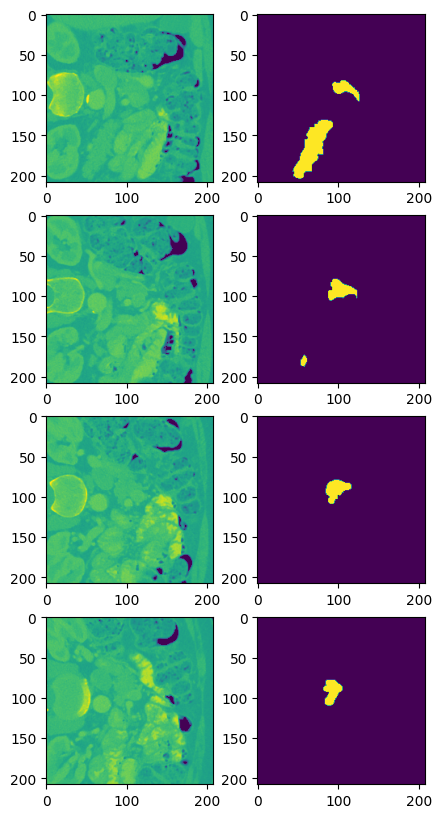

In [24]:
slice_no = [50, 60, 70, 80]

# Create a figure and subplots
plt.figure(figsize=(80, 50))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(5, 10))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_train[0][0][slice_no[i]], (X_train.shape[3], X_train.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_train[0][0][slice_no[i]], (y_train.shape[3], y_train.shape[4], 1)))

In [25]:
# Evaluate the model
for i in range(trainImages, trainImages + testImages):
    # Process input and label images
    img,img1 = process_image(imageFiles[i])
    X = img
    Y = process_label(labelFiles[i])
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img = img1[:,frontz:backz, frontx:backx, fronty:backy]
    img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    img=remove_background2(img)
    #clahe = skimage.exposure.equalize_adapthist
    
    #img=remove_background2(img)
    #img = clahe(img, clip_limit=2.00)

    # Resize and store input images
    X_test[i-trainImages] = np.resize(img, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_img = y_img[:,:,frontz:backz, frontx:backx, fronty:backy]
    y_test[i-trainImages] = np.resize(y_img.cpu().numpy(), (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(sum(y_img))))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(sum(y_img))))) / sum(sum(sum(sum(sum(Y))))))

65 

  z: 128
   x: 208
 y: 208
   x: 150    22    x: 215    7    y: 210    2
tensor(82153.)    tensor(82153.)    Pancreas percentage: tensor(1.)
66 

  z: 128
   x: 208
 y: 208
   x: 141    13    x: 208    0    y: 208    0
tensor(103322.)    tensor(103509.)    Pancreas percentage: tensor(0.9982)
67 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 211    3    y: 225    17
tensor(132946.)    tensor(135109.)    Pancreas percentage: tensor(0.9840)
68 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 216    8    y: 208    0
tensor(64789.)    tensor(64789.)    Pancreas percentage: tensor(1.)
69 

  z: 128
   x: 208
 y: 208
   x: 158    30    x: 249    41    y: 208    0
tensor(101061.)    tensor(101061.)    Pancreas percentage: tensor(1.)
70 

  z: 128
   x: 208
 y: 208
   x: 153    25    x: 224    16    y: 259    51
tensor(98882.)    tensor(98882.)    Pancreas percentage: tensor(1.)
71 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 218    10    y: 208    0
tensor(134686.)    tensor(1

In [26]:
# Evaluate the model
for i in range(trainImages + testImages, trainImages + testImages + valImages):
    # Process input and label images
    img,img1 = process_image(imageFiles[i])
    X = img
    Y = process_label(labelFiles[i])
    y_img = Y
    print(i+1, "\n")
    
    # Convert inputs and targets to PyTorch variables and move them to GPU
    inputs = Variable(X).type(dtype)
    targets = Variable(Y).type(dtype)
    
    # Predict along z-axis
    yhatz = modelz(inputs.unsqueeze(0))
    yhatz = (yhatz > 0.5) * 1.0
    frontz, backz=resize_mid(yhatz.cpu().detach().numpy(),im_depth1,im_depth)
    #frontz, backz = clean_array(yhatz)
    print("  z:", backz - frontz)
    
    # Predict along x-axis
    yhatx = modelx(inputs.unsqueeze(0))
    yhatx = (yhatx > 0.5) * 1.0
    frontx, backx=resize_mid(yhatx.cpu().detach().numpy(),im_height1,im_height)
    #frontx, backx = clean_array(yhatx)
    print("   x:", backx - frontx)
    
    # Predict along y-axis
    yhaty = modely(inputs.unsqueeze(0))
    yhaty = (yhaty > 0.5) * 1.0
    fronty, backy=resize_mid(yhaty.cpu().detach().numpy(),im_width1,im_width)
    #fronty, backy = clean_array(yhaty)
    print(" y:", backy - fronty)
    
    #print(img.shape)
    # Remove background and reconstruct using wavelet transform
    img = img1[:,frontz:backz, frontx:backx, fronty:backy]
    img,val=normalize_image(img)
    
    # Apply CLAHE to the 3D image
    img=remove_background2(img)
    clahe = skimage.exposure.equalize_adapthist
    
    #img=remove_background2(img)
    #img = clahe(img, clip_limit=2.00)

    # Resize and store input images
    X_val[i-trainImages-testImages] = np.resize(img, (1, im_depth1, im_height1, im_width1))
    # Resize and store label images
    y_img = y_img[:,:,frontz:backz, frontx:backx, fronty:backy]
    y_val[i-trainImages-testImages] = np.resize(y_img.cpu().numpy(), (1, im_depth1, im_height1, im_width1))
    '''
    print(Y.shape)
    
    print(img.shape)
    print(y_img.shape)
    print(Y.shape)'''
    print("   x:", backz, "  ", frontz, "   x:", backx, "  ", frontx, "   y:", backy, "  ", fronty)
    print(sum(sum(sum(sum(sum(y_img))))),
          "  ", sum(sum(sum(sum(sum(Y))))), "   Pancreas percentage:", sum(sum(sum(sum(sum(y_img))))) / sum(sum(sum(sum(sum(Y))))))

73 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 231    23    y: 230    22
tensor(107136.)    tensor(107151.)    Pancreas percentage: tensor(0.9999)
74 

  z: 128
   x: 208
 y: 208
   x: 157    29    x: 235    27    y: 208    0
tensor(103345.)    tensor(103345.)    Pancreas percentage: tensor(1.)
75 

  z: 128
   x: 208
 y: 208
   x: 152    24    x: 236    28    y: 208    0
tensor(79001.)    tensor(79155.)    Pancreas percentage: tensor(0.9981)
76 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 219    11    y: 244    36
tensor(94045.)    tensor(94045.)    Pancreas percentage: tensor(1.)
77 

  z: 128
   x: 208
 y: 208
   x: 150    22    x: 217    9    y: 208    0
tensor(119997.)    tensor(119997.)    Pancreas percentage: tensor(1.)
78 

  z: 128
   x: 208
 y: 208
   x: 142    14    x: 209    1    y: 270    62
tensor(70179.)    tensor(74157.)    Pancreas percentage: tensor(0.9464)
79 

  z: 128
   x: 208
 y: 208
   x: 162    34    x: 215    7    y: 247    39
tensor(137190.)    t

<Figure size 10000x6000 with 0 Axes>

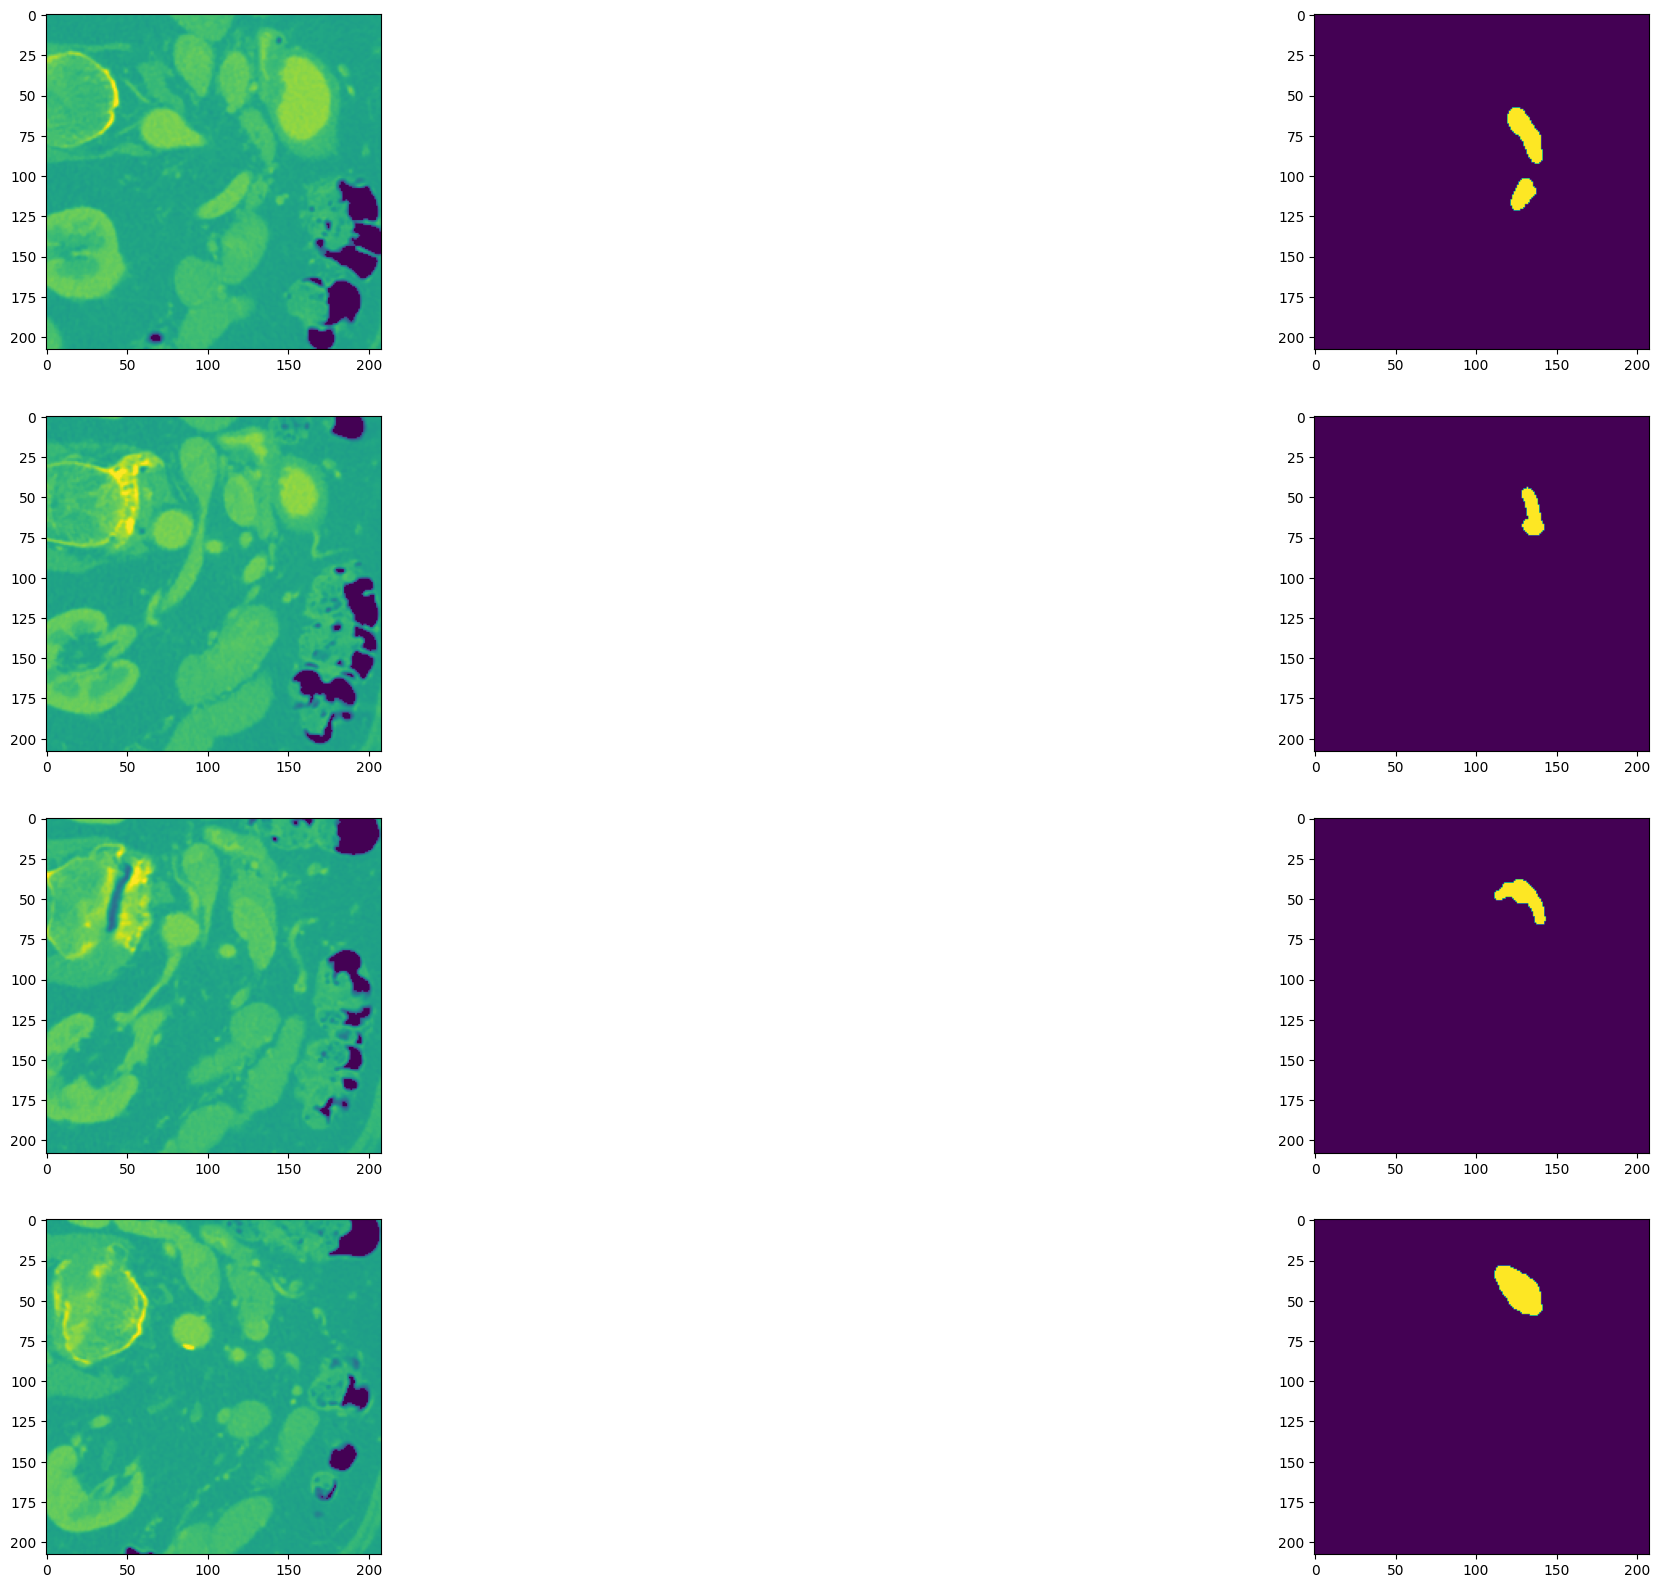

In [27]:
slice_no = [50, 60, 70, 80]
val=2
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

<Figure size 10000x6000 with 0 Axes>

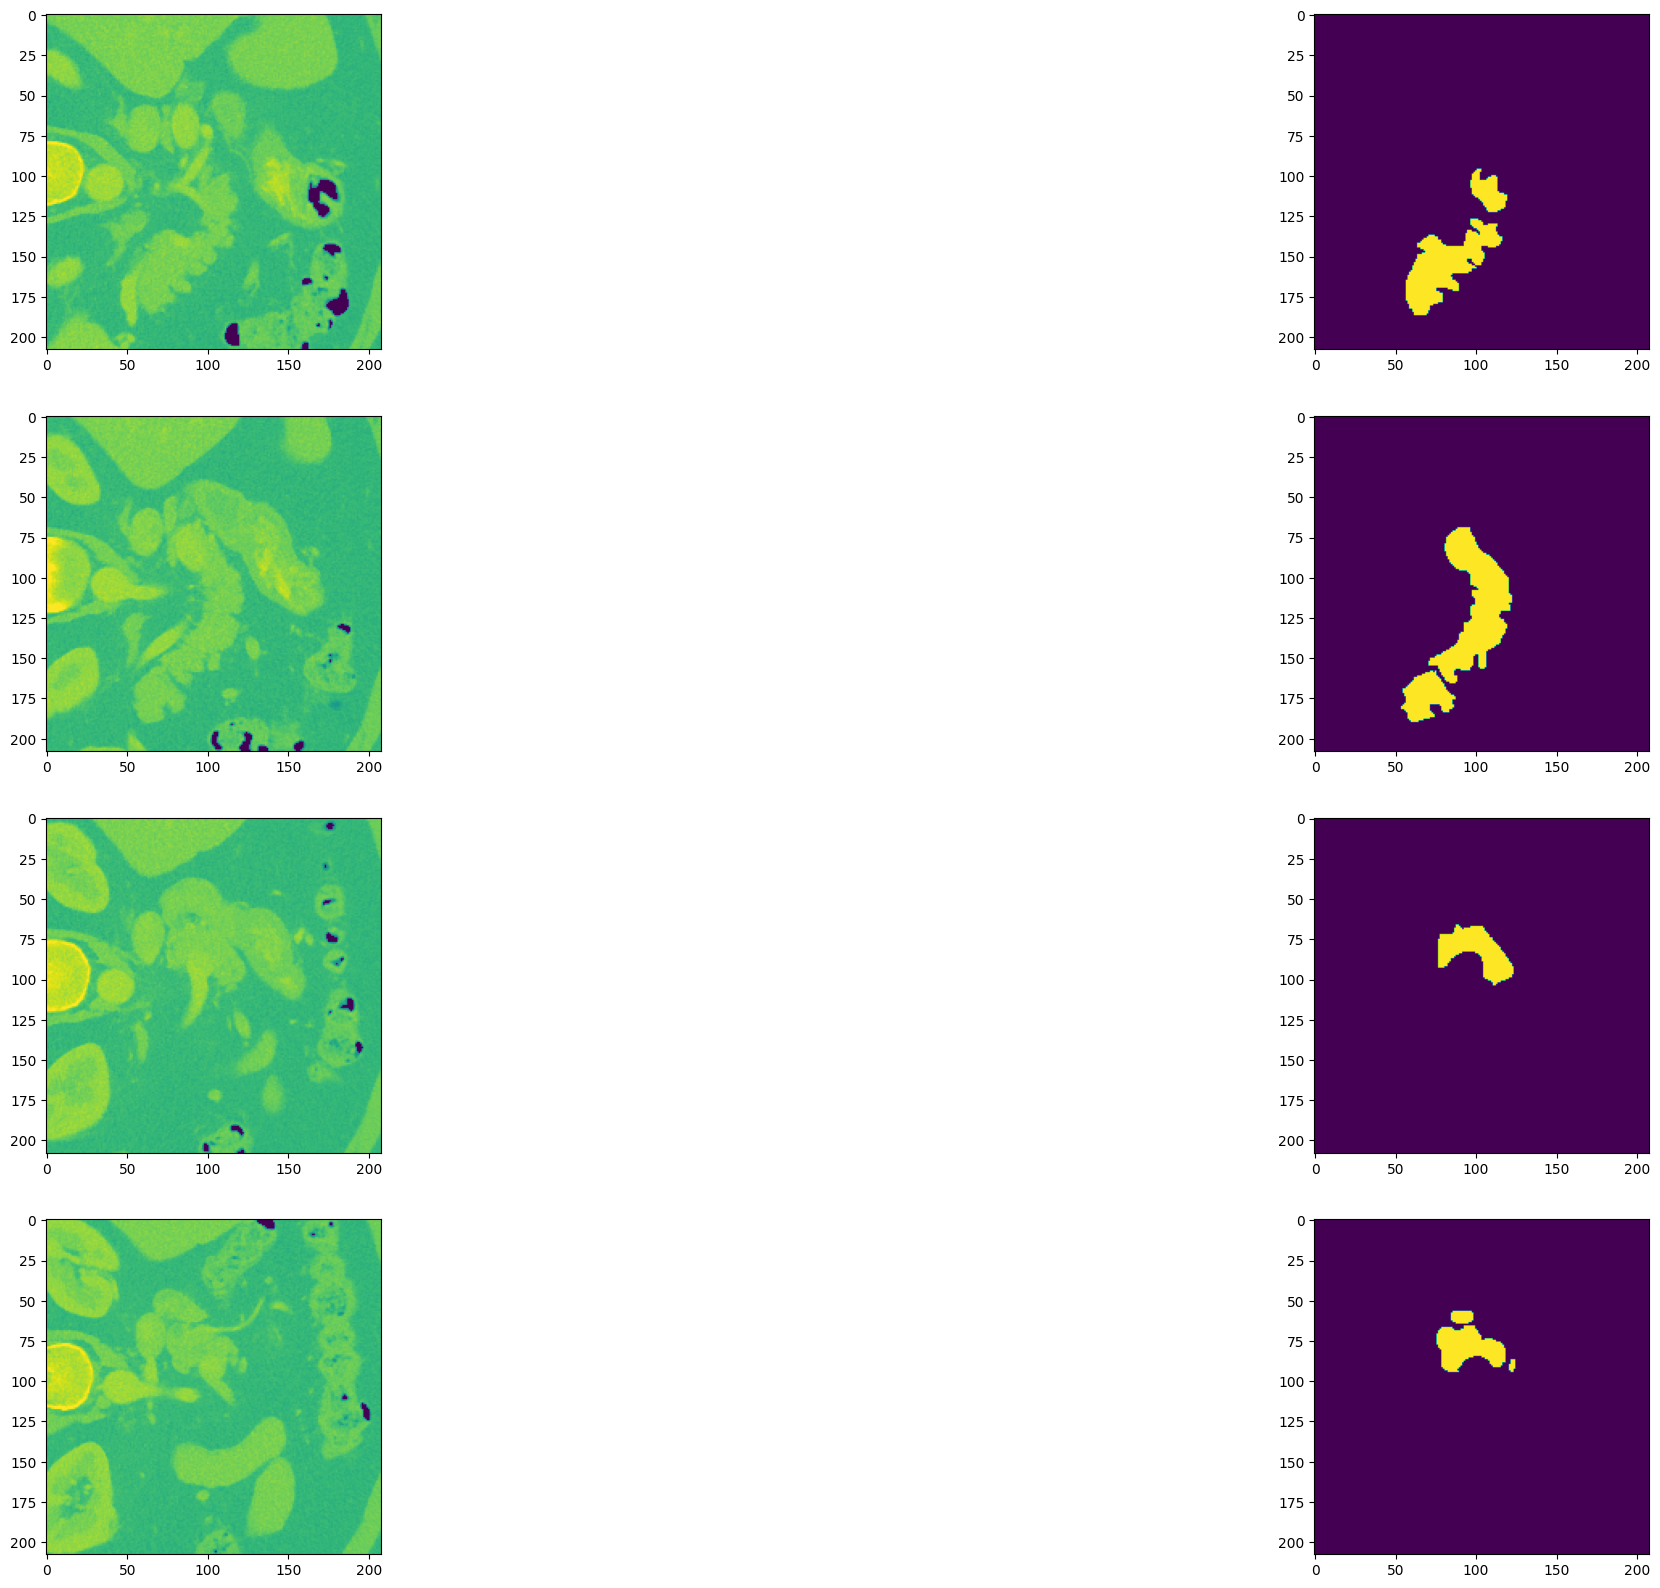

In [28]:
slice_no = [50, 60, 70, 80]
val=3
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

<Figure size 10000x6000 with 0 Axes>

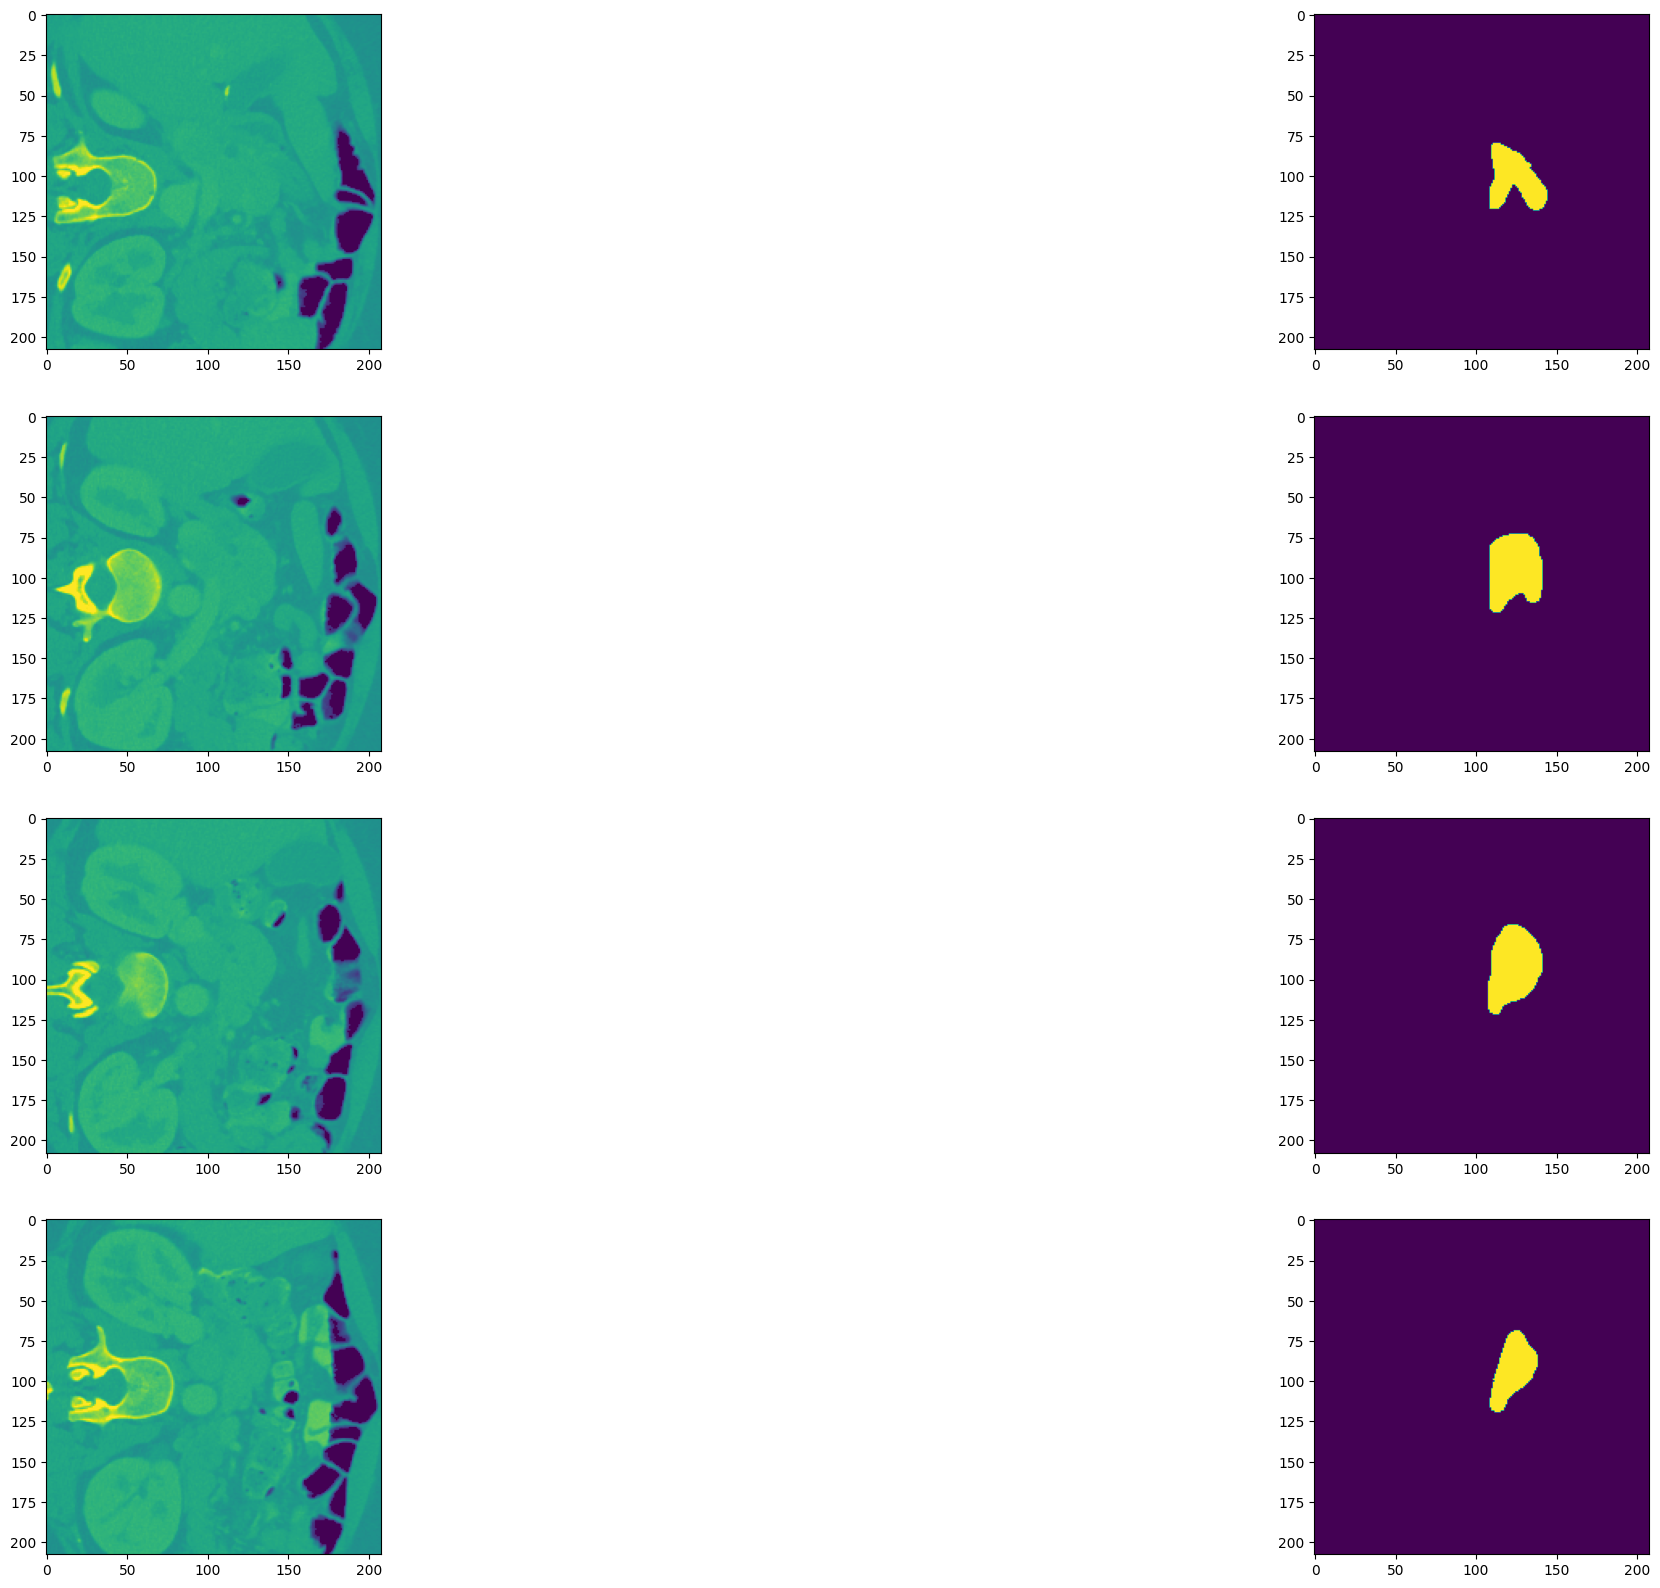

In [29]:
slice_no = [50, 60, 70, 80]
val=4
# Create a figure and subplots
plt.figure(figsize=(100, 60))
f, axarr = plt.subplots(len(slice_no), 2, figsize=(30, 20))

# Iterate over each slice number
for i in range(len(slice_no)):
    # Display the input image in the left subplot
    axarr[i][0].imshow(np.resize(X_val[val][0][slice_no[i]], (X_val.shape[3], X_val.shape[4], 1)))
    # Display the corresponding label image in the right subplot
    axarr[i][1].imshow(np.resize(y_val[val][0][slice_no[i]], (y_val.shape[3], y_val.shape[4], 1)))

In [30]:
# Convert NumPy arrays to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [31]:
class Conv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlock.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Conv3DBlock, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = self.upconv1 = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            #nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1, stride=(1, 1, 1))
        )

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.conv1(input)
        return res

In [32]:
class Conv3DBlockc(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlockc.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Conv3DBlockc, self).__init__()

        # Define the convolutional layers
        self.conv1 = self.upconv1 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(2,2,2),padding=0, stride=(2,2,2)),
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            #nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3, 3), padding=1, stride=1)
        )

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.conv1(input)
        return res

In [33]:
class Residualdense(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        """
        Constructor method for Conv3DBlockc.

        Args:
        - in_channels: Number of input channels
        - out_channels: Number of output channels
        - kernel_size: Size of the convolutional kernel
        - padding: Padding added to the input during convolution
        - stride: Stride of the convolution
        """
        super(Residualdense, self).__init__()

        # Define the convolutional layers
        self.block1 = Conv3DBlock(in_channels=in_channels, out_channels=in_channels)
        
        #self.dense_block1 = Conv3DBlock(in_channels=in_channels*2, out_channels=in_channels)
        

    def forward(self, input):
        # Perform the forward pass through the convolutional layers
        res = self.block1(input)
        
        #res=torch.cat((input,res),1)
        #res= self.dense_block1(res)
        return res

# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Wg and Ws
        self.Wg = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c)
        )
        
        # Define the activation function
        self.relu = nn.ReLU(inplace=True)
        
        # Define the output transformation
        self.output = nn.Sequential(
            nn.Conv3d(out_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        
        # Combine the transformed tensors and apply the activation function
        out = self.relu(Wg + Ws)
        
        # Apply the output transformation and return the result
        out = self.output(out)
        return out * s

In [34]:
# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Wg and Ws
        self.Wg = nn.Sequential(
            nn.Conv3d(in_c*2, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c),
            nn.ReLU()
        )
        
    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        out = self.Wg(torch.cat((g,s),1))
        
        # Apply the output transformation and return the result
        #out = self.output(out)
        return out

# Define an attention gate module
class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super(attention_gate, self).__init__()

        # Define the transformation functions Ws
        self.Ws = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm3d(out_c),
            nn.LeakyReLU(0.2)
        )

    def forward(self, g, s):
        # Apply the transformation functions to the input tensors
        Ws = self.Ws(s)
        
        return Ws

In [35]:
# Define an upsampling convolutional block module
class UPConv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlock, self).__init__()

        # Define the layers of the upsampling convolutional block
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            #nn.ConvTranspose3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [36]:
# Define an upsampling convolutional block module with trilinear interpolation
class UPConv3DBlockc(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1):
        super(UPConv3DBlockc, self).__init__()

        # Define the layers of the upsampling convolutional block with trilinear interpolation
        self.upconv1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.ConvTranspose3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU()
            #nn.ConvTranspose3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        )

    def forward(self, input):
        # Forward pass through the upsampling convolutional block
        res = self.upconv1(input)
        return res

In [37]:
# Define the UNet3D model
class UNET3D(nn.Module):
    # Define model elements
    def __init__(self, in_channels, out_channels):
        super(UNET3D, self).__init__()
        level = [8, 16, 32, 64, 128]
        
        # Input batch normalization layer
        self.in1 = nn.BatchNorm3d(in_channels)
        
        # Encoding blocks
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level[0])
        #self.d_block1 = Residualdense(in_channels=level[0], out_channels=level[0])
        
        # Linear block
        #self.lin1 = nn.Linear(im_depth1 ,im_depth1)
        #self.lin2 = nn.Linear(im_height1 ,im_height1)
        #self.lin3 = nn.Linear(im_width1 ,im_width1)
        
        # Pooling blocks
        self.p_block1 = Conv3DBlockc(in_channels=level[0], out_channels=level[1])
        #self.d_block2 = Residualdense(in_channels=level[1], out_channels=level[1])
        
        self.p_block2 = Conv3DBlockc(in_channels=level[1], out_channels=level[2])
        #self.d_block3 = Residualdense(in_channels=level[2], out_channels=level[2])
        
        self.p_block3 = Conv3DBlockc(in_channels=level[2], out_channels=level[3])
        
        self.p_block4 = Conv3DBlockc(in_channels=level[3], out_channels=level[4])
        #self.d_block4 = Residualdense(in_channels=level[3], out_channels=level[3])
        
        # Dropout layers
        self.drop = nn.Dropout(0.0)
        self.drop1 = nn.Dropout(0.0)
        self.drop2 = nn.Dropout(0.0)
        self.drop3 = nn.Dropout(0.0)
        self.drop4 = nn.Dropout(0.0)
        
        # Decoding blocks
        self.b_block1 = UPConv3DBlock(in_channels=level[4], out_channels=level[4])
        
        
        self.u_block0 = UPConv3DBlockc(in_channels=level[4], out_channels=level[3])
        self.att0 = attention_gate(level[3], level[3])
        
        self.u_block1 = UPConv3DBlockc(in_channels=level[3], out_channels=level[2])
        
        # Attention gates
        self.att1 = attention_gate(level[2], level[2])
        
        # Further decoding blocks
        self.u_block2 = UPConv3DBlockc(in_channels=level[2], out_channels=level[1])
        self.att2 = attention_gate(level[1], level[1])
        
        self.u_block3 = UPConv3DBlockc(in_channels=level[1], out_channels=level[0])
        self.att3 = attention_gate(level[0], level[0])
        
        # Final decoding blocks
        self.b_block4 = UPConv3DBlock(in_channels=level[0], out_channels=level[0])
        #self.d_block5 = Residualdense(in_channels=level[0], out_channels=level[0])
        
        # Final convolution and sigmoid activation
        self.b_block6 = UPConv3DBlock(in_channels=level[0], out_channels=level[0])
        self.out = nn.Conv3d(in_channels=level[0], out_channels=out_channels, kernel_size=3, padding=1, stride=1)
        self.sigmoid_layer = nn.Sigmoid()
    
    # Forward propagate input
    def forward(self, inputs):
        inputs = self.in1(self.drop(inputs))
        
        # Encoding path
        conv1 = self.a_block1(inputs)
        #conv1 = self.d_block1(conv1)
        
        # Attention mechanism
        #conv1=self.lin1(conv1.transpose(2,4))
        #conv1=conv1.transpose(2,4)
        
        #conv1=self.lin2(conv1.transpose(3,4))
        #conv1=conv1.transpose(3,4)
        
        #conv1=self.lin3(conv1)
        
        # Pooling path
        conv2 = self.drop1(conv1)
        conv2 = self.p_block1(conv2)
        #conv2 = self.d_block2(conv2)
        conv3 = self.drop2(conv2)
        
        conv3 = self.p_block2(conv3)
        #conv3 = self.d_block3(conv3)
        conv4 = self.drop3(conv3)
        
        conv4 = self.p_block3(conv4)
        
        conv5 = self.p_block4(conv4)
        #conv4 = self.d_block4(conv4)
        
        conv5 = self.drop4(conv5)
        
        # Decoding path
        convt = self.b_block1(conv5)
        convt = self.u_block0(convt)
        
        
        convt = self.att0(conv4, convt)
        convt = self.u_block1(convt)
        
        #convt = self.drop3(convt)
        # Attention mechanism
        convt = self.att1(conv3, convt)
        #convt = self.drop2(convt)
        
        convt = self.u_block2(convt)
        convt = self.att2(conv2, convt)
        #convt = self.drop1(convt)
        
        convt = self.u_block3(convt)
        convt = self.att3(conv1, convt)
        #convt = torch.cat((conv1,convt),1)
        convt = self.b_block4(convt)
        #convt = self.d_block5(convt)
        
        # Final decoding and sigmoid activation
        convt = self.b_block6(convt)
        out = self.out(convt)
        out = self.sigmoid_layer(out)
        return out

In [38]:
torch.cuda.is_available()

True

In [39]:
torch.cuda.device_count()

1

In [40]:
# Create an instance of the UNet3D model
model = UNET3D(in_channels=1, out_channels=1)

# Move the model to CUDA (GPU)
model.cuda()

# Display the summary of the model
summary(model=model, input_size=(1, im_depth1, im_height1, im_width1), batch_size=1, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1      [1, 1, 128, 208, 208]               0
       BatchNorm3d-2      [1, 1, 128, 208, 208]               2
            Conv3d-3      [1, 8, 128, 208, 208]             224
       BatchNorm3d-4      [1, 8, 128, 208, 208]              16
              ReLU-5      [1, 8, 128, 208, 208]               0
       Conv3DBlock-6      [1, 8, 128, 208, 208]               0
           Dropout-7      [1, 8, 128, 208, 208]               0
         MaxPool3d-8       [1, 8, 64, 104, 104]               0
            Conv3d-9      [1, 16, 64, 104, 104]           3,472
      BatchNorm3d-10      [1, 16, 64, 104, 104]              32
             ReLU-11      [1, 16, 64, 104, 104]               0
     Conv3DBlockc-12      [1, 16, 64, 104, 104]               0
          Dropout-13      [1, 16, 64, 104, 104]               0
        MaxPool3d-14        [1, 16, 32,

In [41]:
def initialize_weights(model):
    """
    Initializes weights according to a specific scheme for certain types of layers in the RCNN model.

    Args:
    - model: The RCNN model

    Returns:
    - None
    """
    # Iterate over all modules in the model
    for m in model.modules():
        # Check if the module is an instance of Conv3d and ConvTranspose3d
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d,nn.BatchNorm3d)):
            # Initialize weights of the module's weight data with normal distribution
            # Mean = 0.0, Standard deviation = 0.6
            nn.init.normal_(m.weight.data, 0.0, 0.6)

In [42]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection) / (inputs.sum() + targets.sum())

        # Return 1 - dice coefficient as loss
        return 1 - dice

In [43]:
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and dice coefficient
        intersection = (inputs * targets).sum()
        dice = (2. * intersection) / (inputs.sum() + targets.sum())

        # Return 1 - dice coefficient as loss
        return dice

In [44]:
class Precision(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(Precision, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate true positives and false positives
        true_positives = torch.sum(predictions * targets)
        false_positives = torch.sum(predictions) - true_positives

        # Calculate precision
        precision = true_positives / (true_positives + false_positives + self.epsilon)
        return precision

In [45]:
class Recall(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(Recall, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate true positives and false negatives
        true_positives = torch.sum(predictions * targets)
        false_negatives = torch.sum(targets) - true_positives

        # Calculate recall
        recall = true_positives / (true_positives + false_negatives + self.epsilon)
        return recall

In [46]:
class IoU(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(IoU, self).__init__()
        self.epsilon = epsilon

    def forward(self, predictions, targets):
        # Calculate intersection and union
        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions) + torch.sum(targets) - intersection

        # Calculate IoU
        iou = (intersection + self.epsilon) / (union + self.epsilon)
        return iou

In [47]:
# Define the optimization criteria and optimizer

# Use Dice Loss as the optimization criterion
criterion = DiceLoss()

# Alternatively, you can use other custom loss functions such as Precision, Recall, or IoU
criterion0 = Dice()
criterion1 = Precision()
criterion2 = Recall()
criterion3 = IoU()
# Define the primary loss function (Binary Cross Entropy Loss)
criterion4 = nn.BCELoss()

#criterion=nn.L1Loss()
#criterion =torch.nn.MSELoss()

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.99)

# Evaluate the model

In [48]:
BATCH_SIZE=1

In [49]:
# enumerate epochs
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.99, weight_decay=1e-10)
lrate=0.005
MIN_LOSS = 10
# Lists to store losses
loss_DICE = []
loss_PRE = []
loss_REC = []
loss_IOU = []
loss_BIN = []

test_loss_DICE = []
test_loss_PRE = []
test_loss_REC = []
test_loss_IOU = []
test_loss_BIN = []

val_loss_DICE = []
val_loss_PRE = []
val_loss_REC = []
val_loss_IOU = []
val_loss_BIN = []

loss_checkpoint=0
epochs=100
l1=10
change_lr=0
val_lr=3
for epoch in range(epochs):
    b = "Loading "
    count=0
    loss=0
    test_loss=0
    val_loss=0
    
    loss1=0
    test_loss1=0
    val_loss1=0
    
    loss2=0
    test_loss2=0
    val_loss2=0
    
    loss3=0
    test_loss3=0
    val_loss3=0
    
    loss4=0
    test_loss4=0
    val_loss4=0
    
    # enumerate mini batches
    #model.train()
    for i in range(0,trainImages):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        inputs=Variable(X_train[i],requires_grad=True).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        
        # Calculate DICE loss
        loss_bcd = (criterion4(yhat, targets)*0.003)+criterion(yhat, targets)
        
        # Credit assignment
        loss_bcd.backward()
        optimizer.step()
    #model.eval()
    
    for i in range(0,trainImages):
        #print(b,i+1,"               ", end="\r")
        inputs=Variable(X_train[i]).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        loss_bcd = criterion(yhat, targets)
        loss+=loss_bcd.cpu().detach().numpy()

    b = "Loss Loading "
    # evaluate the model
    loss=0
    for i in range(0,trainImages):
        #print(b,i+1,"               ", end="\r")
        inputs=Variable(X_train[i]).type(dtype)
        targets=Variable(y_train[i].unsqueeze(0)).type(dtype)
        
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        loss_bcd = criterion(yhat, targets)
        loss+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion1(yhat, targets)
        loss1+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion2(yhat, targets)
        loss2+=loss_bcd.cpu().detach().numpy()
        
        
        loss_bcd = criterion3(yhat, targets)
        loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        loss4+=loss_bcd.cpu().detach().numpy()

        
    if(epoch<5):
        lr_threhold=0.03
    elif(epoch<10):
        lr_threhold=0.01
    elif(epoch<20):
        lr_threhold=0.005
    elif(epoch<30):
        lr_threhold=0.003
    elif(epoch<50):
        lr_threhold=0.001
    elif(epoch<60):
        lr_threhold=0.0005
    if ((loss/trainImages)-l1)<lr_threhold:
        change_lr=change_lr+1
        if(change_lr>=val_lr):
            change_lr=0
            lrate=lrate/2
            print("\n\nLearning rate: ",lrate,"\n\n")
            optimizer = SGD(model.parameters(), lr=lrate, momentum=0.99,weight_decay=1e-10)
    else:
        change_lr=0
    
    if 0.40<=(loss/trainImages):
        val_lr=5
    if l1<=(loss/trainImages):
        l1=(loss/trainImages)
    else:
        change_lr+=2
        
        
    for i in range(trainImages, trainImages + testImages):
        inputs=Variable(X_test[i-trainImages]).type(dtype)
        targets=Variable(y_test[i-trainImages].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        
        loss_bcd = criterion0(yhat, targets)
        test_loss+=loss_bcd.cpu().detach().numpy()    
        
        loss_bcd = criterion1(yhat, targets)
        test_loss1+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion2(yhat, targets)
        test_loss2+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion3(yhat, targets)
        test_loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        test_loss4+=loss_bcd.cpu().detach().numpy()
    
    for i in range(trainImages + testImages, trainImages + testImages + valImages):
        inputs=Variable(X_val[i-trainImages-testImages]).type(dtype)
        targets=Variable(y_val[i-trainImages-testImages].unsqueeze(0)).type(dtype)
        yhat = model(inputs.unsqueeze(0))
        yhat=(yhat>0.5)*1.0
        
        loss_bcd = criterion0(yhat, targets)
        val_loss+=loss_bcd.cpu().detach().numpy()    
        
        loss_bcd = criterion1(yhat, targets)
        val_loss1+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion2(yhat, targets)
        val_loss2+=loss_bcd.cpu().detach().numpy() 
        
        loss_bcd = criterion3(yhat, targets)
        val_loss3+=loss_bcd.cpu().detach().numpy()
        
        loss_bcd = criterion4(yhat, targets)
        val_loss4+=loss_bcd.cpu().detach().numpy()
        
    print("\n",epoch,"Training loss Dice",((1-(loss*BATCH_SIZE)/trainImages)),", Precision",((loss1*BATCH_SIZE)/trainImages),
          ", Recall",((loss2*BATCH_SIZE)/trainImages),", IOU",(loss3*BATCH_SIZE)/trainImages,", Binary Cross Entropy",(loss4*BATCH_SIZE)/trainImages,
      
      "Testing loss Dice:",test_loss/testImages,", Precision",test_loss1/testImages,
          ", Recall",test_loss2/testImages,", IOU",test_loss3/testImages,", Binary Cross entropy",test_loss4/testImages,
          
          "Validation loss Dice:",val_loss/valImages,", Precision",val_loss1/valImages,
          ", Recall",val_loss2/valImages,", IOU",val_loss3/valImages,", Binary Cross entropy",val_loss4/valImages)
    loss_DICE.append(1-((loss*BATCH_SIZE)/trainImages))
    loss_PRE.append((loss1*BATCH_SIZE)/trainImages)
    loss_REC.append((loss2*BATCH_SIZE)/trainImages)
    loss_IOU.append((loss3*BATCH_SIZE)/trainImages)
    loss_BIN.append((loss3*BATCH_SIZE)/trainImages)
    
    test_loss_DICE.append(test_loss/testImages)
    test_loss_PRE.append(test_loss1/testImages)
    test_loss_REC.append(test_loss2/testImages)
    test_loss_IOU.append(test_loss3/testImages)
    test_loss_BIN.append(test_loss4/testImages)
    
    val_loss_DICE.append(val_loss/valImages)
    val_loss_PRE.append(val_loss1/valImages)
    val_loss_REC.append(val_loss2/valImages)
    val_loss_IOU.append(val_loss3/valImages)
    val_loss_BIN.append(val_loss4/valImages)


    if (test_loss/testImages)>loss_checkpoint:
        loss_checkpoint=(test_loss/testImages)
        model=torch.jit.script(model)
        model.save('checkpoint_unet.pt')
        print("Model saved")


 0 Training loss Dice 0.20585217513144016 , Precision 0.11739481764379889 , Recall 0.8925633113831282 , IOU 0.1155788620817475 , Binary Cross Entropy 12.424128666520119 Testing loss Dice: 0.2043268084526062 , Precision 0.1162749556824565 , Recall 0.8660013526678085 , IOU 0.11433703266084194 , Binary Cross entropy 11.989803671836853 Validation loss Dice: 0.17727913428097963 , Precision 0.10015694797039032 , Recall 0.823788620531559 , IOU 0.0985763780772686 , Binary Cross entropy 13.4033362865448
Model saved

 1 Training loss Dice 0.38810212071985006 , Precision 0.2713864737888798 , Recall 0.7173861322226003 , IOU 0.24628499220125377 , Binary Cross Entropy 4.029283370822668 Testing loss Dice: 0.4126696437597275 , Precision 0.2875057337805629 , Recall 0.7480799034237862 , IOU 0.26685682218521833 , Binary Cross entropy 3.82229283452034 Validation loss Dice: 0.31573155560181476 , Precision 0.21425580966752023 , Recall 0.6157076389645226 , IOU 0.19465588900493458 , Binary Cross entropy 4.50

In [50]:
model=torch.jit.load('checkpoint_unet.pt')

In [51]:
count=0
loss=0
test_loss=0
val_loss=0

loss1=0
test_loss1=0
val_loss1=0

loss2=0
test_loss2=0
val_loss2=0

loss3=0
test_loss3=0
val_loss3=0

loss4=0
test_loss4=0
val_loss4=0
# evaluate the model
for i in range(0,trainImages):
    #print(b,i+1,"               ", end="\r")
    inputs=Variable(X_train[i]).type(dtype)
    targets=Variable(y_train[i].unsqueeze(0)).type(dtype)

    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    loss+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion1(yhat, targets)
    loss1+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion2(yhat, targets)
    loss2+=loss_bcd.cpu().detach().numpy()


    loss_bcd = criterion3(yhat, targets)
    loss3+=loss_bcd.cpu().detach().numpy()
    
    loss_bcd = criterion4(yhat, targets)
    loss4+=loss_bcd.cpu().detach().numpy()

for i in range(trainImages,trainImages + testImages):
    inputs=Variable(X_test[i-trainImages]).type(dtype)
    targets=Variable(y_test[i-trainImages].unsqueeze(0)).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    test_loss+=loss_bcd.cpu().detach().numpy()    

    loss_bcd = criterion1(yhat, targets)
    test_loss1+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion2(yhat, targets)
    test_loss2+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion3(yhat, targets)
    test_loss3+=loss_bcd.cpu().detach().numpy()

    loss_bcd = criterion4(yhat, targets)
    test_loss4+=loss_bcd.cpu().detach().numpy()
    
for i in range(trainImages + testImages,trainImages + testImages+ valImages):
    inputs=Variable(X_val[i-trainImages-testImages]).type(dtype)
    targets=Variable(y_val[i-trainImages-testImages].unsqueeze(0)).type(dtype)
    yhat = model(inputs.unsqueeze(0))
    yhat=(yhat>0.5)*1.0
    loss_bcd = criterion0(yhat, targets)
    val_loss+=loss_bcd.cpu().detach().numpy()    

    loss_bcd = criterion1(yhat, targets)
    val_loss1+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion2(yhat, targets)
    val_loss2+=loss_bcd.cpu().detach().numpy() 

    loss_bcd = criterion3(yhat, targets)
    val_loss3+=loss_bcd.cpu().detach().numpy()

    loss_bcd = criterion4(yhat, targets)
    val_loss4+=loss_bcd.cpu().detach().numpy()

print("\n","Training loss Dice",(1-((loss*BATCH_SIZE)/trainImages)),", Precision",((loss1*BATCH_SIZE)/trainImages),
          ", Recall",((loss2*BATCH_SIZE)/trainImages),", IOU",(loss3*BATCH_SIZE)/trainImages,", Binary Cross Entropy",(loss4*BATCH_SIZE)/trainImages,
      
      "Testing loss Dice:",test_loss/testImages,", Precision",test_loss1/testImages,
          ", Recall",test_loss2/testImages,", IOU",test_loss3/testImages,", Binary Cross entropy",test_loss4/testImages,
          
          "Validation loss Dice:",val_loss/valImages,", Precision",val_loss1/valImages,
          ", Recall",val_loss2/valImages,", IOU",val_loss3/valImages,", Binary Cross entropy",val_loss4/valImages)


 Training loss Dice 0.6118979145539925 , Precision 0.2713864528341219 , Recall 0.7173860931070521 , IOU 0.2462849714793265 , Binary Cross Entropy 4.029283933341503 Testing loss Dice: 0.41266920045018196 , Precision 0.28750530537217855 , Recall 0.7480799034237862 , IOU 0.26685645524412394 , Binary Cross entropy 3.8222996294498444 Validation loss Dice: 0.31573155560181476 , Precision 0.21425580966752023 , Recall 0.6157076389645226 , IOU 0.19465588900493458 , Binary Cross entropy 4.506785064935684


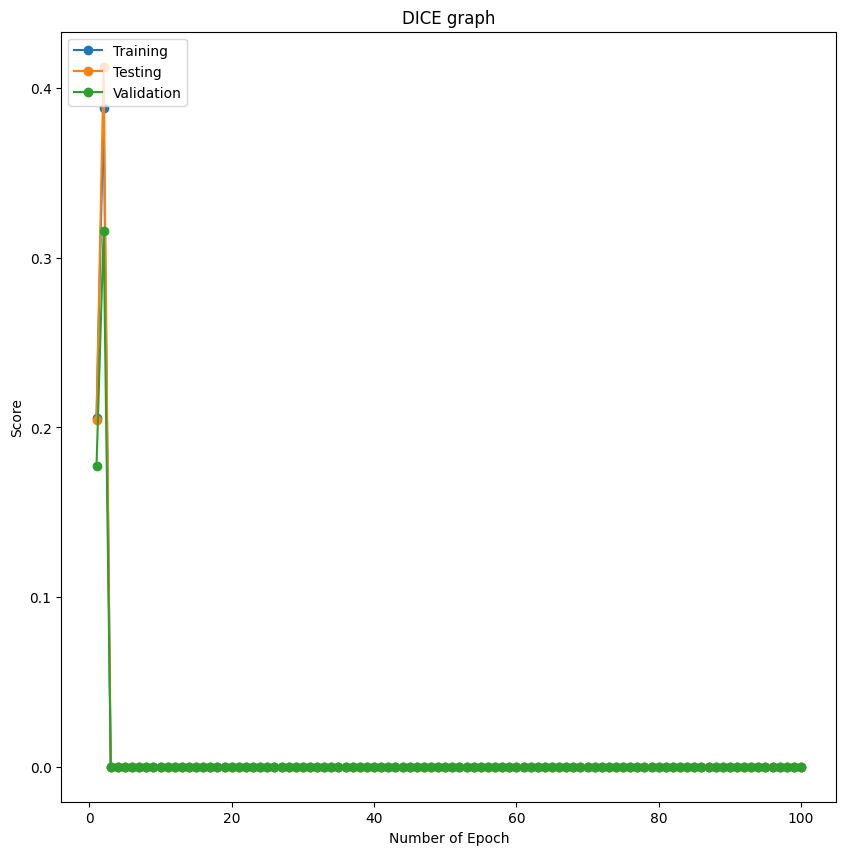

In [52]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("DICE graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_DICE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_DICE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_DICE, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

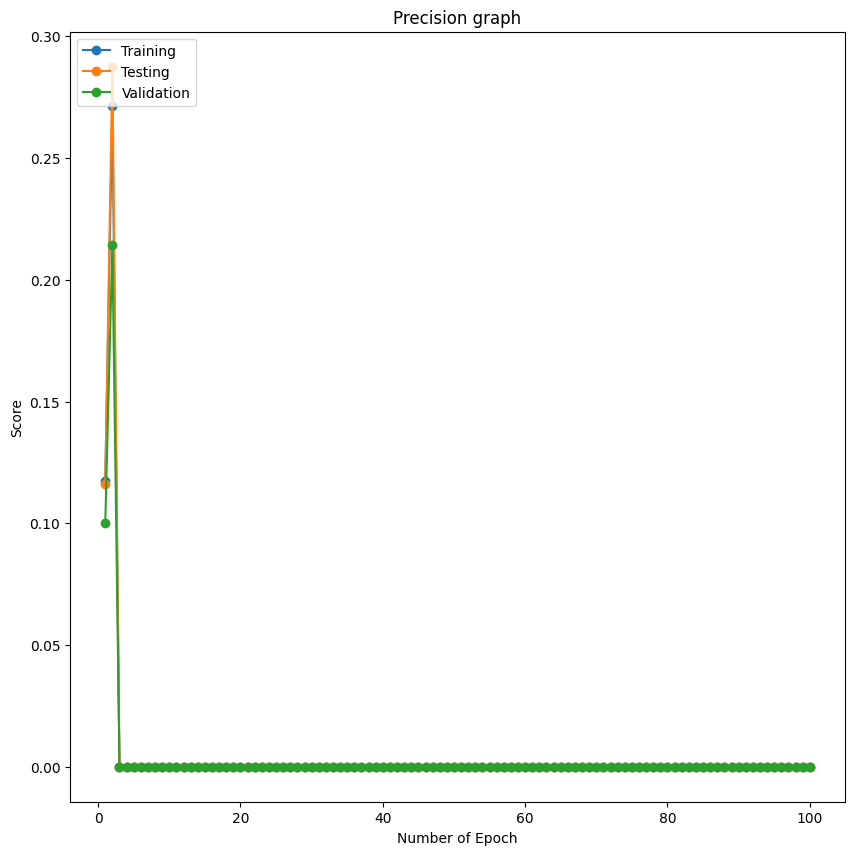

In [53]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Precision graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_PRE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_PRE, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_PRE, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

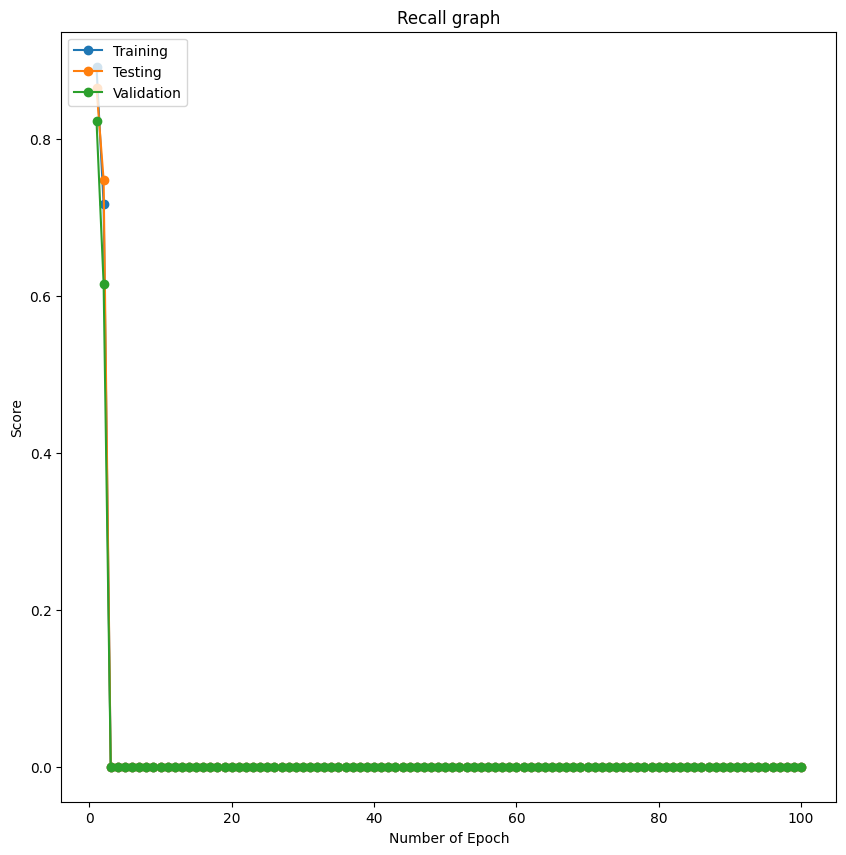

In [54]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Recall graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_REC, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_REC, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_REC, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

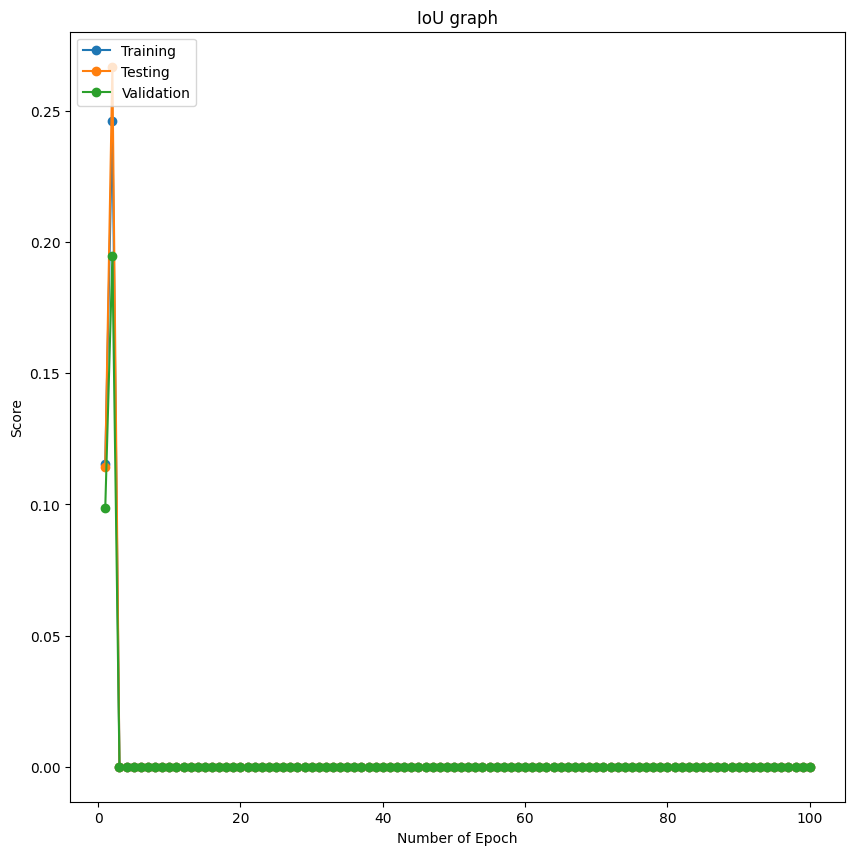

In [55]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("IoU graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_IOU, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_IOU, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_IOU, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

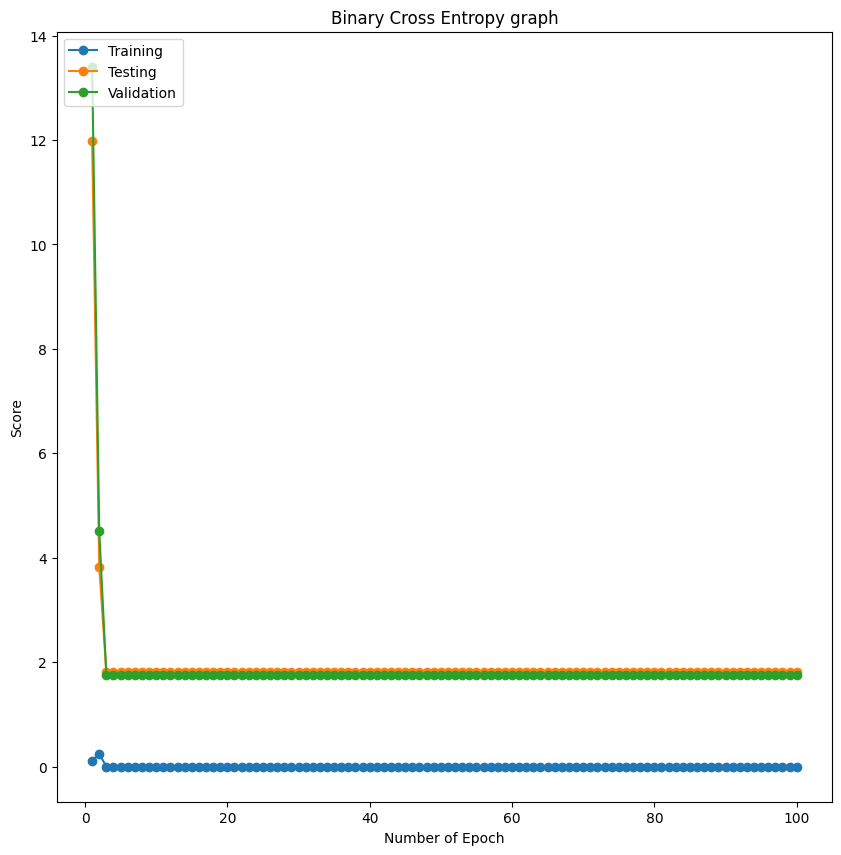

In [56]:
plt.figure(figsize=(10,10))
plt.xlabel("Number of Epoch")
plt.ylabel("Score")
plt.title("Binary Cross Entropy graph")
plt.plot( [i+1 for i in range(0,epochs)],loss_BIN, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],test_loss_BIN, marker='o', linestyle='-')
plt.plot( [i+1 for i in range(0,epochs)],val_loss_BIN, marker='o', linestyle='-')
plt.legend(['Training','Testing','Validation'],loc='upper left')
plt.show()

In [57]:
# Iterate over training images

b = "Evaluation training Loading "
for i in range(0, trainImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(X_train[i]).type(dtype)
    targets = Variable(y_train[i].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each training image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())

# Iterate over testing images
b = "Evaluation test Loading "
for i in range(trainImages, trainImages + testImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(X_test[i - trainImages]).type(dtype)
    targets = Variable(y_test[i - trainImages].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each testing image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())
    
# Iterate over validation images
b = "Evaluation val Loading "
for i in range(trainImages + testImages, trainImages + testImages + valImages):
    # Convert input and target data to PyTorch variables
    inputs = Variable(X_val[i - trainImages - testImages]).type(dtype)
    targets = Variable(y_val[i - trainImages - testImages].unsqueeze(0)).type(dtype)

    # Forward pass: compute predicted outputs by passing inputs to the model
    yhat = model(inputs.unsqueeze(0))
    yhat = (yhat > 0.5) * 1.0

    # Calculate various loss metrics using defined criteria
    loss_bcd = criterion0(yhat, targets)
    loss_bcd1 = criterion1(yhat, targets)
    loss_bcd2 = criterion2(yhat, targets)
    loss_bcd3 = criterion3(yhat, targets)
    loss_bcd4 = criterion4(yhat, targets)
    
    # Print the loss metrics for each validation image
    print(b, i + 1, "  Dice ", loss_bcd.cpu().detach().numpy(), ", Precision ", loss_bcd1.cpu().detach().numpy(), 
          ", Recall ", loss_bcd2.cpu().detach().numpy(), ", IOU ", loss_bcd3.cpu().detach().numpy(),
          ", Binary Cross Entropy ", loss_bcd4.cpu().detach().numpy())

Evaluation training Loading  1   Dice  0.37584493 , Precision  0.23892035 , Recall  0.88039947 , IOU  0.23140952 , Binary Cross Entropy  3.8016958
Evaluation training Loading  2   Dice  0.28474694 , Precision  0.20389758 , Recall  0.4718411 , IOU  0.1660087 , Binary Cross Entropy  4.7951784
Evaluation training Loading  3   Dice  0.36897185 , Precision  0.24478209 , Recall  0.7489507 , IOU  0.22622041 , Binary Cross Entropy  4.0449877
Evaluation training Loading  4   Dice  0.23457041 , Precision  0.16953623 , Recall  0.38054934 , IOU  0.13286874 , Binary Cross Entropy  4.689324
Evaluation training Loading  5   Dice  0.3465625 , Precision  0.21454799 , Recall  0.9008985 , IOU  0.20960121 , Binary Cross Entropy  3.4616144
Evaluation training Loading  6   Dice  0.3154738 , Precision  0.20008159 , Recall  0.74531764 , IOU  0.18727745 , Binary Cross Entropy  3.4209301
Evaluation training Loading  7   Dice  0.46166506 , Precision  0.31437075 , Recall  0.86866826 , IOU  0.300107 , Binary Cross

In [58]:
def print_image(x, y, pred_y, slice_no):
    plt.figure()

    # Create subplots with specified number of rows and columns
    f, axarr = plt.subplots(len(slice_no), 3)

    # Iterate over slice numbers
    for i in range(len(slice_no)):
        # Display original image in the first column
        axarr[i][0].imshow(np.resize(x[0][slice_no[i]], (x.shape[2], x.shape[3], 1)))

        # Display ground truth label in the second column
        axarr[i][1].imshow(np.resize(y[0][slice_no[i]], (y.shape[2], y.shape[3], 1)))

        # Display predicted label in the third column
        axarr[i][2].imshow(np.resize(pred_y[0][slice_no[i]], (pred_y.shape[2], pred_y.shape[3], 1)))

<Figure size 640x480 with 0 Axes>

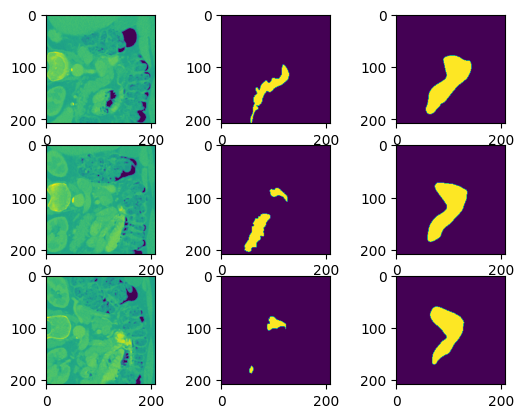

In [59]:
inputs=Variable(X_train[0]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_train[0],y_train[0],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

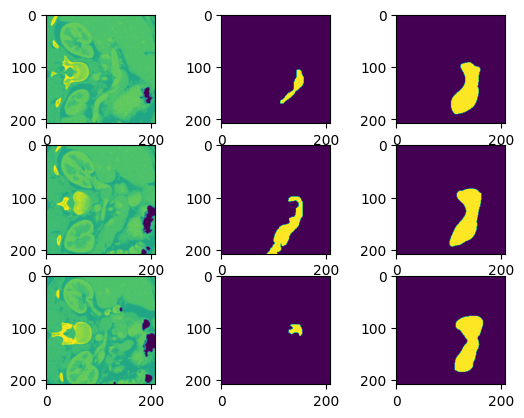

In [60]:
inputs=Variable(X_train[4]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_train[4],y_train[4],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

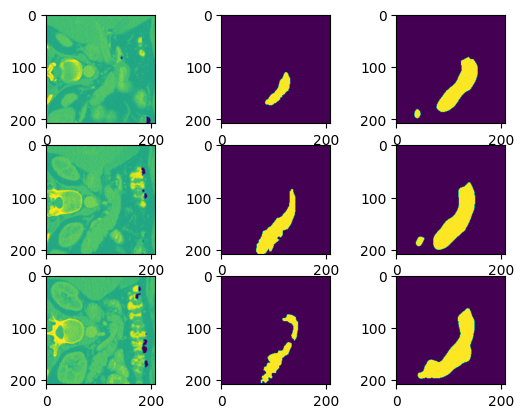

In [61]:
inputs=Variable(X_test[1]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_test[1],y_test[1],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

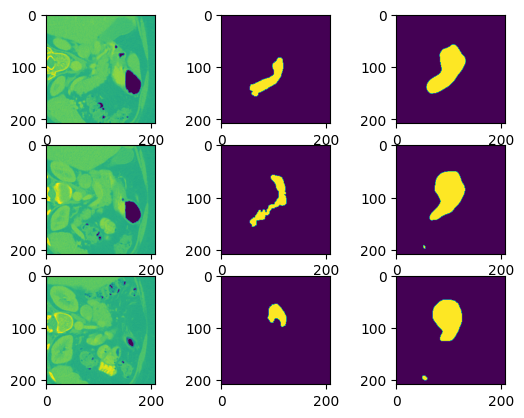

In [62]:
inputs=Variable(X_test[3]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_test[3],y_test[3],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

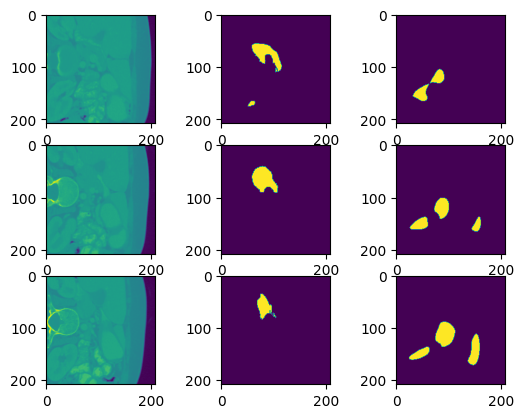

In [63]:
inputs=Variable(X_val[1]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[1],y_val[1],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

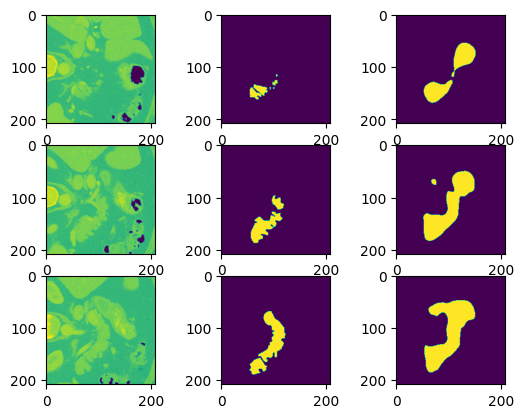

In [64]:
inputs=Variable(X_val[3]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[3],y_val[3],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])

<Figure size 640x480 with 0 Axes>

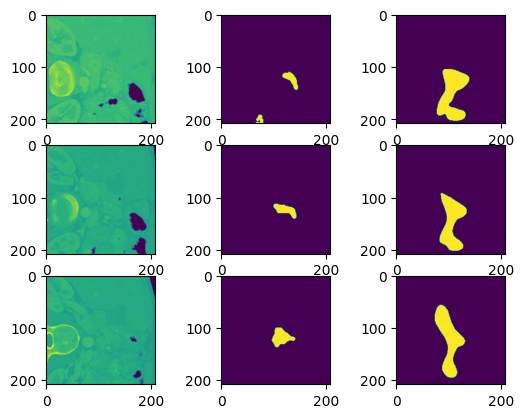

In [65]:
inputs=Variable(X_val[5]).type(dtype)
yhat = model(inputs.unsqueeze(0))
print_image(X_val[5],y_val[5],((yhat>0.5)).cpu().detach().numpy()[0],[40,50,60])